### Imports

In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import pathlib
import tensorflow as tf
import os
import tensorflow.keras.applications     as     applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import seaborn as sns

In [52]:
sns.set_context('talk')
sns.set_style('dark')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../utilities/')
from utilities import Timer, show_image, DreamImage, DeepDream, class_names, ProgressBar, plot_confusion_matrix

### Setup

In [4]:
sns.set()

AUTOTUNE = tf.data.experimental.AUTOTUNE

width = height = 224
batch_size = 32

### Load the Model

In [6]:
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

# Remove dropout
model = Sequential()
for layer in base_model.layers[:-1]:
    if isinstance(layer, Dropout):
        pass
    else:
        model.add(layer)

### Load the Data in Special Form

In [7]:
# Load the list of file names in the form of data_dir/class_name/file_name.jpg
data_subdir = 'test'
data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

dataset_size = len(list(list_ds))

In [8]:
# Function to get the label
#  Modification: get just the class name, not the vector
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

# Function to get the image
def decode_img(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize
    return tf.image.resize(img, [width, height])

# Preprocess
def preprocess_img(img, label, file_path):
    return applications.vgg19.preprocess_input(img), label, file_path

In [9]:
# Combine both processes
def process_path(file_path):
    return decode_img(file_path), get_label(file_path), file_path

In [10]:
def embed_image(img_batch, label_batch, file_path_batch):
    return model(img_batch), label_batch, file_path_batch

In [11]:
# Create the dataset
ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
ds = ds.map(preprocess_img)
ds = ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
ds = ds.map(embed_image)
ds = ds.cache()

### Compute Embedding on the Dataset

Commented out because this is slow; only do once

In [12]:
# bar = ProgressBar(dataset_size // batch_size + 1)

# class_batches     = []
# label_batches     = []
# file_path_batches = []
# bar.start()
# iterations = 0
# for class_batch, label_batch, file_path_batch in ds:
#     class_batches.append(class_batch)
#     label_batches.append(label_batch)
#     file_path_batches.append(file_path_batch)
#     iterations+=1
#     bar.update(iterations)

### Extract Embeddings into a Convenient Numpy Array

In [16]:
# Convert to a single array
def concat_batches(batch_list):
    batch_list = [tensor.numpy() for tensor in batch_list]
    return np.concatenate(batch_list)

embedding  = concat_batches(class_batches)
labels     = concat_batches(label_batches)
file_paths = concat_batches(file_path_batches)

df = pd.concat([pd.Series(labels, name = 'artist'), pd.Series(file_paths, name = 'file_path'), pd.DataFrame(embedding)], axis = 'columns')
df.to_csv(f'{model_name}-embedding.csv')

### Load the Data

In [44]:
model_name = 'vgg19-INet-down2-b'
df = pd.read_csv(f'{model_name}-embedding.csv', index_col=0)

meta_data_cols = ['artist', 'file_path']
meta_data = df[meta_data_cols]

data = df.drop(meta_data_cols, axis = 'columns')
print(f'{len(df)} samples, {data.shape[1]} neurons')

# Embarassingly, 2813 of the 4096 neurons have died and never activate
num_zeros_in_col = (data == 0).sum()
is_dead_col      = num_zeros_in_col == len(data)
print(f'{is_dead_col.sum()} of the neurons are dead')

# Let's drop the offending columns
data = data.drop(is_dead_col[is_dead_col].index.tolist(), axis = 'columns')
print(f'Summary of the percentage of the time each living neuron activates')
print((data != 0).mean().describe())

2941 samples, 4096 neurons
2813 of the neurons are dead
Summary of the percentage of the time each neuron activates
count    1283.000000
mean        0.015131
std         0.059972
min         0.000340
25%         0.000680
50%         0.001700
75%         0.006800
max         0.550833
dtype: float64


In [46]:
pca = PCA(n_components=50, random_state = 42)

In [47]:
data_pcaed = pca.fit_transform(data)

In [53]:
pd.DataFrame(data_pcaed)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,4.892086,-5.522586,47.732862,-31.990748,6.567371,-12.643597,-7.233413,-6.142749,-16.854956,44.170211,...,7.784182,1.461763,-5.985889,-2.022709,-1.801923,-0.991873,3.023692,-2.250994,-1.552175,-3.159682
1,4.473963,-7.170889,-15.339654,-4.041886,6.044818,1.109875,0.411673,-8.503962,-4.123009,-1.517648,...,7.092055,-0.825971,1.370573,-2.873106,-0.902847,3.136550,-2.277053,0.927152,1.718873,2.627172
2,9.427109,-11.150616,-21.235184,3.278773,11.649579,-7.105455,-7.835313,-12.275794,-7.906952,-8.826778,...,3.142667,-2.515524,1.514547,2.293885,-0.984948,1.210498,-1.521036,1.809598,2.651290,-0.005578
3,15.676716,-22.659795,43.501320,11.642479,-51.932691,25.176981,20.759345,31.923070,-0.203171,-34.258228,...,-4.258977,-4.056597,-3.312956,2.350663,-2.254147,-1.486126,1.959238,-0.153623,4.080725,1.334131
4,-215.098724,153.603521,26.261389,89.139371,-7.031368,33.059331,-43.361523,-13.223167,-7.202605,-24.463132,...,3.760449,4.929800,0.310561,-4.245099,0.857347,1.538947,6.229873,-1.832022,1.054687,-1.302777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,-11.495814,1.895466,-14.384186,-20.926899,2.935505,-1.296770,27.445991,1.464296,13.270634,-10.389638,...,2.196619,-8.903481,0.759318,0.432827,-7.526903,5.490114,-1.394030,4.538586,-1.057966,-9.591357
2937,-25.909632,18.036576,-24.832946,-25.147073,-7.374236,84.590614,-20.199449,-16.192588,33.579688,5.653789,...,5.006880,1.704553,0.352254,1.128569,2.214462,0.178021,-1.466828,2.356975,-4.567921,-2.227706
2938,-36.185040,13.012886,12.405160,-24.971518,-9.698784,3.818076,-2.473670,-25.814237,-5.500328,36.714973,...,-6.920764,-0.090423,8.635006,-5.066324,0.368925,6.691568,-3.321797,-3.007966,-1.314530,2.342439
2939,-216.980876,153.875662,31.308621,88.571835,-0.943511,-7.275101,-14.863258,-9.596872,-17.102019,-18.973136,...,5.165232,3.903945,2.754182,-0.816093,-1.107803,0.871340,2.848738,-5.542742,6.321832,-4.552751


In [57]:
tsne = TSNE(random_state = 42, n_jobs = 3, verbose=1)

In [61]:
data_tsned = tsne.fit_transform(data_pcaed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2941 samples in 0.006s...
[t-SNE] Computed neighbors for 2941 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2941
[t-SNE] Computed conditional probabilities for sample 2000 / 2941
[t-SNE] Computed conditional probabilities for sample 2941 / 2941
[t-SNE] Mean sigma: 10.706505
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.232101
[t-SNE] KL divergence after 1000 iterations: 1.134203


In [79]:
embedding = pd.DataFrame(data_tsned)
embedding.rename({0 : 'x', 1 : 'y'}, axis = 'columns', inplace = True)

embedding = pd.concat([meta_data, embedding], axis = 'columns')

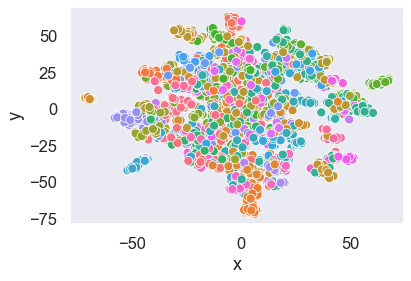

In [92]:
sns.scatterplot(x = 'x', y = 'y', hue = 'artist', data = embedding, legend=False);